In [244]:
# -*- coding: utf-8 -*-   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [245]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc", size=14)

In [246]:
db = pd.read_excel(r'C:\Users\ren.x.1\Desktop\JD_Pricing\JD\JFM_HC_ePOS.xlsx',encoding='gbk')
db.shape

(25331, 20)

In [247]:
#db.dropna(inplace = True)

In [248]:
db.BrandName.value_counts()

海飞丝             6646
沙宣（VS）          6536
潘婷（pantene）     6369
飘柔（Rejoice）     4630
伊卡璐（CLAIROL）     953
袋鼠（Aussie）       141
Hair Recipe       53
吉列（Gillette）       3
Name: BrandName, dtype: int64

In [249]:
# df = db[db.BrandName == u'沙宣（VS）']
df = db.copy()

In [250]:
df.Abnormal.value_counts()

normal              24975
abnormal - back       238
abnormal - front      118
Name: Abnormal, dtype: int64

In [251]:
# exclude coupon,promotion pack, abnormal wholesale
df = df[- df.Mechanism.str.contains(u"领券")]
df = df[df.Mechanism != 'PP']
df = df[df.Abnormal == 'normal']

In [109]:
# df.Date = pd.to_datetime(df.Date)

In [252]:
# visualize PE chart
def jointplt(ProductCode,df):
    SKU = df[df['ProductCode'] == ProductCode][['Sales_Price',u'Sales_Num','uv']]
    SKU['Productivity'] = (SKU.Sales_Num/SKU.uv)
    SKU['LogProductivity'] =  np.log(SKU['Productivity'])
    SKU['LogSalesPrice'] = np.log(SKU['Sales_Price'])
    sns.jointplot(x="LogSalesPrice", y="LogProductivity", kind = 'reg', color = 'r', data=SKU)

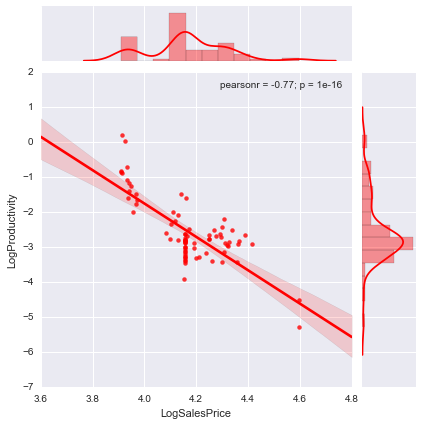

In [254]:
jointplt(206808,df)

In [211]:
# log-log Regression, p-value and pearson correlation control
from scipy.stats.stats import pearsonr

def logReg(ProductCode,df):
    SKU = df[df.ProductCode == ProductCode]
    x = np.log(SKU.Sales_Price)
    y = np.log(SKU.Sales_Num/SKU.uv)
    pearson = pearsonr(x,y)[0]
    #print pearson
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value < 0.05 and abs(pearson) >= 0.5:
        return np.round(slope,decimals=2)
    else:
        return np.nan

In [212]:
# # log-log Regression, p-value and pearson correlation control, groupby adopted
# slow-performing, need optimization
# from scipy.stats.stats import pearsonr

# def logReg(ProductCode,df):
#     SKU = df[df.ProductCode == ProductCode]
#     SKU['productivity'] = np.round(SKU.Sales_Num/SKU.uv,decimals = 2)
#     temp = SKU[['Sales_Price','productivity']]
#     temp['Sales_Price'] = np.round(temp.Sales_Price,decimals = 1)
#     temp = temp.groupby('Sales_Price',as_index=False).mean()
#     x = np.log(temp.Sales_Price)
#     y = np.log(temp.productivity)
#     pearson = pearsonr(x,y)[0]
#     #print pearson
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#     if p_value < 0.05 and abs(pearson) >= 0.5:
#         return np.round(slope,decimals=2)
#     else:
#         return np.nan

In [242]:
 #suggest the price as mean of the prices that contibuted top 5 productivities in the past
def suggestPrice(ProductCode,df): 
    SKU = df[df.ProductCode == ProductCode]
    SKU['productivity'] = np.round(SKU.Sales_Num/SKU.uv,decimals = 2)
    temp = SKU[['Sales_Price','productivity']]
    temp['Sales_Price'] = np.round(temp.Sales_Price,decimals = 1)
    #temp.sort(['productivity'],ascending=False)
    return temp.groupby('Sales_Price',as_index=False).mean().sort(['productivity'],ascending=False).head(5).Sales_Price.mean()

**Three-Chanel split: TPR, 199-100, others**

In [218]:
df.Mechanism.value_counts()

single TPR    5819
满159减60       4249
满199减100      2939
3件7折 4件6折     2139
满199减80       1607
满99减30        1259
赠品/国际店         483
Name: Mechanism, dtype: int64

In [219]:
# 1-TPR; 2-199-100; 3-Others
df1 = df[df.Mechanism == 'single TPR']

df2 = df[df.Mechanism == u'满199减100']

mask3 = (df.Mechanism != 'single TPR') & (df.Mechanism != u'满199减100')

df3 = df[mask3]

In [220]:
df3.Mechanism.value_counts()

满159减60      4249
3件7折 4件6折    2139
满199减80      1607
满99减30       1259
赠品/国际店        483
Name: Mechanism, dtype: int64

In [221]:
PE_1 = {}
for code in df1.ProductCode:
    PE_1[code] = logReg(code,df1)

PE_DF1 =  pd.DataFrame.from_dict(PE_1, orient='index')
PE_DF1.columns = ['TPR_PE']

In [222]:
PE_DF1['TPR_PD10PI'] = np.round(np.exp(np.log(1.1)*PE_DF1['TPR_PE']) - 1,decimals = 2)

In [226]:
PE_2 = {}
for code in df2.ProductCode:
    PE_2[code] = (logReg(code,df2),suggestPrice(code,df2))

PE_DF2 =  pd.DataFrame.from_dict(PE_2, orient='index')
PE_DF2.columns =['199-100_PE','199-100_SuggestPrice']

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [227]:
# calculate the productivity drop% when price up 10%
PE_DF2['199-100_PD10PI'] = np.round(np.exp(np.log(1.1)*PE_DF2['199-100_PE']) - 1, decimals = 2)

In [260]:
PE_DF2.head()

,199-100_PE,199-100_SuggestPrice,199-100_PD10PI
411151,Mark,26.48,Mark
301621,-1.57,27.22,-0.14
301622,-1.2,26.84,-0.11
301623,-2.47,31.92,-0.21
1093694,-1.19,34.16,-0.11


In [230]:
PE_3 = {}
for code in df3.ProductCode:
    PE_3[code] = logReg(code,df3)

PE_DF3 =  pd.DataFrame.from_dict(PE_3, orient='index')
PE_DF3.columns =['Others_PE']

In [231]:
PE_DF3['Others_PD10PI'] = np.round(np.exp(np.log(1.1)*PE_DF3['Others_PE']) - 1, decimals = 2)

In [232]:
PE_DF3.head()

,Others_PE,Others_PD10PI
773202,NaN,NaN
411151,-2.68,-0.23
411118,NaN,NaN
845098,-4.01,-0.32
301621,NaN,NaN


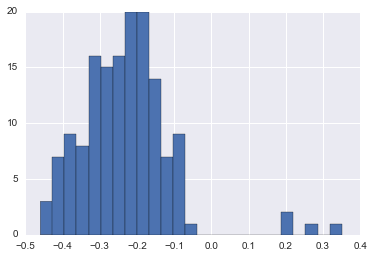

In [233]:
PE_DF3.Others_PD10PI.hist(bins = 25)

In [234]:
for d in [PE_DF1,PE_DF2,PE_DF3]:
    d.replace(np.nan,'Mark',inplace = True)

In [235]:
# Merge different mechanisms
PE_ByMech_1 = PE_DF1.join(PE_DF2,how='outer')
PE_ByMech = PE_ByMech_1.join(PE_DF3,how='outer')

In [236]:
PE_ByMech.replace(np.nan,'NoData',inplace=True)
PE_ByMech.head()

,TPR_PE,TPR_PD10PI,199-100_PE,199-100_SuggestPrice,199-100_PD10PI,Others_PE,Others_PD10PI
206626,Mark,Mark,-4.6,31.18,-0.35,-3.4,-0.28
206627,Mark,Mark,Mark,17.26,Mark,-1.58,-0.14
206628,-2.91,-0.24,NoData,NoData,NoData,-2.42,-0.21
206629,Mark,Mark,-3.29,31.5,-0.27,-3.89,-0.31
206631,Mark,Mark,NoData,NoData,NoData,Mark,Mark


In [237]:
# output = pd.merge(df, PE_ByMech, how='left',left_on=['ProductCode'],right_index = True)
# output.to_excel('JD_HC_ePOS_PE_0515.xlsx')

In [238]:
prodNames = []
for idx in PE_ByMech.index:
    prodNames.append(df[df.ProductCode == idx].ProductName.iloc[0])
PE_ByMech['productName'] = prodNames

In [239]:
PE_ByMech.head()

,TPR_PE,TPR_PD10PI,199-100_PE,199-100_SuggestPrice,199-100_PD10PI,Others_PE,Others_PD10PI,productName
206626,Mark,Mark,-4.6,31.18,-0.35,-3.4,-0.28,【京东超市】飘柔洗发水焗油护理750ml（洗头膏 洗发露 头发护理）
206627,Mark,Mark,Mark,17.26,Mark,-1.58,-0.14,【京东超市】飘柔发膜精纯焗油精华300ml(新老包装随机发货）
206628,-2.91,-0.24,NoData,NoData,NoData,-2.42,-0.21,【京东超市】飘柔洗发水人参滋养400ml（洗发露）
206629,Mark,Mark,-3.29,31.5,-0.27,-3.89,-0.31,【京东超市】飘柔洗发水人参滋养750ml（洗头膏 洗发露）
206631,Mark,Mark,NoData,NoData,NoData,Mark,Mark,【京东超市】飘柔去屑洗发水山茶长效柔顺家庭装750ml（洗发露 家庭护理系列）


In [241]:
PE_ByMech.to_excel('JDHC_PEPerMechan_0524.xlsx')